In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! git clone https://github.com/facebookresearch/CPC_audio.git

Cloning into 'CPC_audio'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 84 (delta 13), reused 75 (delta 6), pack-reused 0
Unpacking objects: 100% (84/84), done.


In [ ]:
%cd /content/CPC_audio
!python setup.py develop

/content/CPC_audio
Compiling cpc/eval/ABX/dtw.pyx because it changed.
[1/1] Cythonizing cpc/eval/ABX/dtw.pyx
running develop
running egg_info
creating CPC_audio.egg-info
writing CPC_audio.egg-info/PKG-INFO
writing dependency_links to CPC_audio.egg-info/dependency_links.txt
writing top-level names to CPC_audio.egg-info/top_level.txt
writing manifest file 'CPC_audio.egg-info/SOURCES.txt'
writing manifest file 'CPC_audio.egg-info/SOURCES.txt'
running build_ext
building 'cpc.eval.ABX.dtw' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/cpc
creating build/temp.linux-x86_64-3.6/cpc/eval
creating build/temp.linux-x86_64-3.6/cpc/eval/ABX
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I/usr/include/python3.6m -c cpc/eval/ABX/dtw.c -o build/temp.linux-x86_64-3.6/cpc/eval/ABX/

In [ ]:
!pip install torchaudio
!pip install PyDrive
!pip install soundfile

     |████████████████████████████████| 3.2MB 2.7MB/s 


In [ ]:
import torch
import torchaudio

# Part 1 : contrastive predictive coding

Contrastive Predictive Coding (CPC) is a method of unsupervised training for speech models. The idea behind it is pretty simple:


1.   The raw audio wave is passed through a convolutional network: the ```encoder```
2.   Then, the encoder's output is given to a recurrent network the ```context```
3. A third party network, the ```prediction_network``` will try to predict the  future embeddings of the encoder using the output of the context network.

In order to avoid a collapse to trivial solutions, the prediction_network doesn't try to reconstruct the future features. Instead, using the context output $c_t$ at time $t$ it is trained to discriminate the real  encoder representatioin $g_{t+k}$ at time $t+k$ from several other features $(g_n)_n$ taken elsewhere in the batch. Thus the loss becomes:

\\[ \mathcal{L}_c = - \frac{1}{K} \sum_{k=1}^K \text{Cross_entropy}(\phi_k(c_t), g_{t+k}) \\]

Or:

\\[ \mathcal{L}_c = - \frac{1}{K} \sum_{k=1}^K \log \frac{ \exp\left(\phi_k(c_t)^\top g_{t+k}\right) }{  \sum_{\mathbf{n}\in\mathcal{N}_t} \exp\left(\phi_k(c_t)^\top g_n\right)} \\]

Where:


*   $\phi_k$ is the prediction network for the kth timestep
*   $\mathcal{N}_t$ is the set of all negative examples sampled for timestep $t$




## Exercice 1 : Building the model

In this exercise, we will build and train a small CPC model using the repository CPC_audio.

The code below loads a context and an encoder newtorks.

In [ ]:
%cd /content/CPC_audio
from cpc.model import CPCEncoder, CPCAR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/content/CPC_audio


In [ ]:
# Several functions that will be necessary to load the data later
from cpc.dataset import findAllSeqs, AudioBatchData, parseSeqLabels
SIZE_WINDOW = 20480
BATCH_SIZE=8
def load_dataset(path_dataset, file_extension='.wav', phone_label_dict=None):
  data_list, speakers = findAllSeqs(path_dataset, extension=file_extension)
  dataset = AudioBatchData(path_dataset, SIZE_WINDOW, data_list, phone_label_dict, len(speakers))
  return dataset

# Part 2 : Fine tuning

## Exercice 1 : Phone separability with aligned phonemes.

One option to evaluate the quality of the features trained with CPC can be to check if they can be used to recognize phonemes. 
To do so, we can fine-tune a pre-trained model using a limited amount of labelled speech data.
We are going to start with a simple evaluation setting where we have the phone labels for each timestep corresponding to a CPC feature.

We will work with a model already pre-trained on English data. As far as the fine-tuning dataset is concerned, we will use a 1h subset of [librispeech-100](http://www.openslr.org/12/). 

In [ ]:
!mkdir checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_30.pt -P checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_logs.json -P checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_args.json -P checkpoint_data
!ls checkpoint_data

--2020-07-05 13:19:03--  https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_30.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113599715 (108M) [application/octet-stream]
Saving to: ‘checkpoint_data/checkpoint_30.pt’

checkpoint_30.pt    100%[===================>] 108.34M  11.8MB/s    in 10s     

2020-07-05 13:19:14 (10.4 MB/s) - ‘checkpoint_data/checkpoint_30.pt’ saved [113599715/113599715]

--2020-07-05 13:19:19--  https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_logs.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request 

In [ ]:
class PhoneClassifier(torch.nn.Module):

  def __init__(self,
               input_dim : int,
               n_phones : int):
    super(PhoneClassifier, self).__init__()
    self.linear = torch.nn.Linear(input_dim, n_phones)
    

  def forward(self, x):
    return self.linear(x)

Our phone classifier will then be:

## Exercise 2 : Phone separability without alignment (PER)

Aligned data are very practical, but un real life they are rarely available. That's why in this excercise we will consider a fine-tuning with non-aligned phonemes.

The model, the optimizer and the phone classifier will stay the same. However, we will replace our phone criterion with a [CTC loss](https://pytorch.org/docs/master/generated/torch.nn.CTCLoss.html). 

In [ ]:
loss_ctc = torch.nn.CTCLoss(zero_infinity=True)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
import torch.nn.functional as F

def train_one_epoch_ctc(cpc_model, 
                        phone_classifier, 
                        loss_criterion, 
                        data_loader, 
                        optimizer):
  
  cpc_model.train()
  loss_criterion.train()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  avg_loss_list = []
  for step, full_data in tqdm(enumerate(data_loader), total=len(data_loader)):

    x, x_len, y, y_len = full_data

    x_batch_len = x.shape[-1]
    x, y = x.to(device), y.to(device)

    bs=x.size(0)
    optimizer.zero_grad()
    context_out, enc_out, _ = cpc_model(x.to(device),y.to(device))
  
    scores = phone_classifier(context_out)
    scores = scores.permute(1,0,2)
    scores = F.log_softmax(scores,2)
    yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough

    loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
    loss.backward()
    optimizer.step()
    avg_loss+=loss.item()*bs
    n_items+=bs

    avg_loss_list.append(avg_loss / bs)
  avg_loss /= n_items
  return avg_loss, avg_loss_list

def validation_step(cpc_model, 
                    phone_classifier, 
                    loss_criterion, 
                    data_loader):

  cpc_model.eval()
  phone_classifier.eval()
  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  avg_loss_list = []
  with torch.no_grad():
    for step, full_data in tqdm(enumerate(data_loader), total=len(data_loader)):

      x, x_len, y, y_len = full_data

      x_batch_len = x.shape[-1]
      x, y = x.to(device), y.to(device)

      bs=x.size(0)
      context_out, enc_out, _ = cpc_model(x.to(device),y.to(device))
    
      scores = phone_classifier(context_out)
      scores = scores.permute(1,0,2)
      scores = F.log_softmax(scores,2)
      yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough

      loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
      avg_loss+=loss.item()*bs
      n_items+=bs

      avg_loss_list.append(avg_loss / bs)
  avg_loss /= n_items

  return avg_loss, avg_loss_list

def run_ctc(cpc_model, 
            phone_classifier, 
            loss_criterion, 
            data_loader_train, 
            data_loader_val, 
            optimizer,
            n_epoch):
  train_losses = []
  valid_losses = []
  for epoch in range(n_epoch):

    print(f"Running epoch {epoch + 1} / {n_epoch}")
    loss_train, l1 = train_one_epoch_ctc(cpc_model, phone_classifier, loss_criterion, data_loader_train, optimizer)
    #train_losses += l1
    train_losses.append(loss_train)
    print("-------------------")
    print(f"Training dataset :")
    print(f"Average loss : {loss_train}.")

    print("-------------------")
    print("Validation dataset")
    loss_val, l2 = validation_step(cpc_model, phone_classifier, loss_criterion, data_loader_val)
    #valid_losses += l2
    valid_losses.append(loss_val)
    print(f"Average loss : {loss_val}")
    print("-------------------")
    print()
  return train_losses, valid_losses

### b- Evaluation: the Phone Error Rate (PER)

In order to compute the similarity between two sequences, we can use the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance). This distance estimates the minimum number of insertion, deletion and addition to move from one sequence to another. If we normalize this distance by the number of characters in the reference sequence we get the Phone Error Rate (PER).

This value can be interpreted as :
\\[  PER = \frac{S + D + I}{N} \\]

Where:


*   N is the number of characters in the reference
*   S is the number of substitutiion
*   I in the number of insertion
*   D in the number of deletion

For the best possible alignment of the two sequences.



In [ ]:

import numpy as np

def get_PER_sequence(ref_seq, target_seq):

  # re = g.split()
  # h = h.split()
  n = len(ref_seq)
  m = len(target_seq)

  D = np.zeros((n+1,m+1))
  for i in range(1,n+1):
    D[i,0] = D[i-1,0]+1
  for j in range(1,m+1):
    D[0,j] = D[0,j-1]+1
  
  ### TODO compute the alignment

  for i in range(1,n+1):
    for j in range(1,m+1):
      D[i,j] = min(
          D[i-1,j]+1,
          D[i-1,j-1]+1,
          D[i,j-1]+1,
          D[i-1,j-1]+ 0 if ref_seq[i-1]==target_seq[j-1] else float("inf")
      )
  return D[n,m]/len(ref_seq)
  

  #return PER

You can test your function below:

In [ ]:
ref_seq = [0, 1, 1, 2, 0, 2, 2]
pred_seq = [1, 1, 2, 2, 0, 0]

expected_PER = 4. / 7.
print(get_PER_sequence(ref_seq, pred_seq) == expected_PER)

True


## c- Evaluating the PER of your model on the test dataset

Evaluate the PER on the validation dataset. Please notice that you should usually use a separate dataset, called the dev dataset, to perform this operation. However for the sake of simplicity we will work with validation data in this exercise.

In [ ]:
import progressbar
from multiprocessing import Pool

def cut_data(seq, sizeSeq):
    maxSeq = sizeSeq.max()
    return seq[:, :maxSeq]


def prepare_data(data):
    seq, sizeSeq, phone, sizePhone = data
    seq = seq.cuda()
    phone = phone.cuda()
    sizeSeq = sizeSeq.cuda().view(-1)
    sizePhone = sizePhone.cuda().view(-1)

    seq = cut_data(seq.permute(0, 2, 1), sizeSeq).permute(0, 2, 1)
    return seq, sizeSeq, phone, sizePhone


def get_per(test_dataloader,
            cpc_model,
            phone_classifier):

  downsampling_factor = 160
  cpc_model.eval()
  phone_classifier.eval()

  avgPER = 0
  nItems = 0 

  print("Starting the PER computation through beam search")
  bar = progressbar.ProgressBar(maxval=len(test_dataloader))
  bar.start()

  for index, data in enumerate(test_dataloader):

    bar.update(index)

    with torch.no_grad():
      
        seq, sizeSeq, phone, sizePhone = prepare_data(data)
        c_feature, _, _ = cpc_model(seq.to(device),phone.to(device))
        sizeSeq = sizeSeq / downsampling_factor
        predictions = torch.nn.functional.softmax(
        phone_classifier(c_feature), dim=2).cpu()
        phone = phone.cpu()
        sizeSeq = sizeSeq.cpu()
        sizePhone = sizePhone.cpu()

        bs = c_feature.size(0)
        data_per = [(predictions[b].argmax(1),  phone[b]) for b in range(bs)]
        # data_per = [(predictions[b], sizeSeq[b], phone[b], sizePhone[b],
        #               "criterion.module.BLANK_LABEL") for b in range(bs)]

        with Pool(bs) as p:
            poolData = p.starmap(get_PER_sequence, data_per)
        avgPER += sum([x for x in poolData])
        nItems += len(poolData)

  bar.finish()

  avgPER /= nItems

  print(f"Average PER {avgPER}")
  return avgPER


## Exercice 3 : Character error rate (CER) 

The Character Error Rate (CER) is an evaluation metric similar to the PER but with characters insterad of phonemes. Using the following data, run the functions you defined previously to estimate the CER of your model after fine-tuning.

In [ ]:
# Load a dataset labelled with the letters of each sequence.
%cd /content/CPC_audio
from cpc.eval.common_voices_eval import SingleSequenceDataset, parseSeqLabels, findAllSeqs
path_train_data_cer = '/content/drive/My Drive/WOL-GA-DATA/TRAIN'
path_test_data_cer = '/content/drive/My Drive/WOL-GA-DATA/TEST'
path_val_data_cer = '/content/drive/My Drive/WOL-GA-DATA/VALIDATION'
path_letter_data_cer = '/content/drive/My Drive/WOL-GA-DATA/all_sessions_WOL_GA.txt'
BATCH_SIZE=8

letters_labels, N_LETTERS = parseSeqLabels(path_letter_data_cer)
data_train_cer, _ = findAllSeqs(path_train_data_cer, extension='.wav')
dataset_train_non_aligned = SingleSequenceDataset(path_train_data_cer, data_train_cer, letters_labels)


data_val_cer, _ = findAllSeqs(path_val_data_cer, extension='.wav')
dataset_val_non_aligned = SingleSequenceDataset(path_val_data_cer, data_val_cer, letters_labels)

data_test_cer, _ = findAllSeqs(path_test_data_cer, extension='.wav')
dataset_test_non_aligned = SingleSequenceDataset(path_test_data_cer, data_test_cer, letters_labels)


# The data loader will generate a tuple of tensors data, labels for each batch
# data : size N x T1 x 1 : the audio sequence
# label : size N x T2 the sequence of letters corresponding to the audio data
# IMPORTANT NOTE: just like the PER the CER is computed with non-aligned phone data.
data_loader_train_letters = torch.utils.data.DataLoader(dataset_train_non_aligned, batch_size=BATCH_SIZE,
                                                shuffle=True)
data_loader_val_letters = torch.utils.data.DataLoader(dataset_val_non_aligned, batch_size=BATCH_SIZE,
                                              shuffle=True)

data_loader_test_letters = torch.utils.data.DataLoader(dataset_test_non_aligned, batch_size=BATCH_SIZE,
                                              shuffle=True)

1it [00:00, 75.52it/s]

/content/CPC_audio
Saved cache file at /content/drive/My Drive/WOL-GA-DATA/TRAIN/_seqs_cache.txt



1it [00:00, 97.26it/s]

Loaded 942 sequences in 70.37 seconds
maxSizeSeq : 486420
maxSizePhone : 252
minSizePhone : 2
Total size dataset 1.0080764756944445 hours
Saved cache file at /content/drive/My Drive/WOL-GA-DATA/VALIDATION/_seqs_cache.txt



1it [00:00, 54.78it/s]

Loaded 376 sequences in 26.95 seconds
maxSizeSeq : 238854
maxSizePhone : 108
minSizePhone : 5
Total size dataset 0.33503765625 hours
Saved cache file at /content/drive/My Drive/WOL-GA-DATA/TEST/_seqs_cache.txt


Loaded 1059 sequences in 76.32 seconds
maxSizeSeq : 270072
maxSizePhone : 380
minSizePhone : 4
Total size dataset 1.0222710590277777 hours


In [ ]:
from cpc.feature_loader import loadModel
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint_path = 'checkpoint_data/checkpoint_30.pt'
cpc_model, HIDDEN_CONTEXT_MODEL, HIDDEN_ENCODER_MODEL = loadModel([checkpoint_path])
cpc_model = cpc_model.to(device)
character_classifier = PhoneClassifier(HIDDEN_CONTEXT_MODEL, N_LETTERS).to(device)

Loading checkpoint checkpoint_data/checkpoint_30.pt
Loading the state dict at checkpoint_data/checkpoint_30.pt


In [ ]:
parameters = list(character_classifier.parameters()) + list(cpc_model.parameters())
LEARNING_RATE = 2e-4
optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)

optimizer_frozen = torch.optim.Adam(list(character_classifier.parameters()), lr=LEARNING_RATE)

In [ ]:
loss_ctc = torch.nn.CTCLoss(zero_infinity=True)

In [23]:
train_losses, valid_losses =  run_ctc(cpc_model,character_classifier,loss_ctc,data_loader_train_letters,data_loader_val_letters,optimizer_frozen,n_epoch=30)

Running epoch 1 / 30


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.



-------------------
Training dataset :
Average loss : 47.9336694561333.
-------------------
Validation dataset



Average loss : 35.389479888916014
-------------------

Running epoch 2 / 30



-------------------
Training dataset :
Average loss : 33.622054086861525.
-------------------
Validation dataset



Average loss : 23.312179723103842
-------------------

Running epoch 3 / 30



-------------------
Training dataset :
Average loss : 21.425295755789712.
-------------------
Validation dataset



Average loss : 14.451556226094564
-------------------

Running epoch 4 / 30



-------------------
Training dataset :
Average loss : 13.420821721951588.
-------------------
Validation dataset



Average loss : 9.208007354736328
-------------------

Running epoch 5 / 30



-------------------
Training dataset :
Average loss : 8.893163097272136.
-------------------
Validation dataset



Average loss : 6.3432399393717445
-------------------

Running epoch 6 / 30



-------------------
Training dataset :
Average loss : 6.405392357444155.
-------------------
Validation dataset



Average loss : 4.778583278656006
-------------------

Running epoch 7 / 30



-------------------
Training dataset :
Average loss : 4.995643868583168.
-------------------
Validation dataset



Average loss : 3.880768194834391
-------------------

Running epoch 8 / 30



-------------------
Training dataset :
Average loss : 4.156777320075364.
-------------------
Validation dataset



Average loss : 3.3483449287414553
-------------------

Running epoch 9 / 30



-------------------
Training dataset :
Average loss : 3.633655347428844.
-------------------
Validation dataset



Average loss : 3.0053810183207195
-------------------

Running epoch 10 / 30



-------------------
Training dataset :
Average loss : 3.2919519279512413.
-------------------
Validation dataset



Average loss : 2.7808278675079348
-------------------

Running epoch 11 / 30



-------------------
Training dataset :
Average loss : 3.057711116312414.
-------------------
Validation dataset



Average loss : 2.6285983448028563
-------------------

Running epoch 12 / 30



-------------------
Training dataset :
Average loss : 2.891513019768515.
-------------------
Validation dataset



Average loss : 2.5174806543986
-------------------

Running epoch 13 / 30



-------------------
Training dataset :
Average loss : 2.768082843703494.
-------------------
Validation dataset



Average loss : 2.4348974669774375
-------------------

Running epoch 14 / 30



-------------------
Training dataset :
Average loss : 2.673032965087485.
-------------------
Validation dataset



Average loss : 2.370092751820882
-------------------

Running epoch 15 / 30



-------------------
Training dataset :
Average loss : 2.5976077557623576.
-------------------
Validation dataset



Average loss : 2.317607535680135
-------------------

Running epoch 16 / 30



-------------------
Training dataset :
Average loss : 2.53553780460459.
-------------------
Validation dataset



Average loss : 2.273402277628581
-------------------

Running epoch 17 / 30



-------------------
Training dataset :
Average loss : 2.4828936336651113.
-------------------
Validation dataset



Average loss : 2.2349139035542804
-------------------

Running epoch 18 / 30



-------------------
Training dataset :
Average loss : 2.4369979780107958.
-------------------
Validation dataset



Average loss : 2.2001544049580892
-------------------

Running epoch 19 / 30



-------------------
Training dataset :
Average loss : 2.39607086635168.
-------------------
Validation dataset



Average loss : 2.168772796630859
-------------------

Running epoch 20 / 30



-------------------
Training dataset :
Average loss : 2.3588228162366196.
-------------------
Validation dataset



Average loss : 2.1393641777038575
-------------------

Running epoch 21 / 30



-------------------
Training dataset :
Average loss : 2.3242543724214104.
-------------------
Validation dataset



Average loss : 2.1115993989308675
-------------------

Running epoch 22 / 30



-------------------
Training dataset :
Average loss : 2.2917978251778486.
-------------------
Validation dataset



Average loss : 2.084800161997477
-------------------

Running epoch 23 / 30



-------------------
Training dataset :
Average loss : 2.2609478213708534.
-------------------
Validation dataset



Average loss : 2.058912998199463
-------------------

Running epoch 24 / 30



-------------------
Training dataset :
Average loss : 2.2313092517548743.
-------------------
Validation dataset



Average loss : 2.0332034591039023
-------------------

Running epoch 25 / 30



-------------------
Training dataset :
Average loss : 2.202500550830529.
-------------------
Validation dataset



Average loss : 2.00790637811025
-------------------

Running epoch 26 / 30



-------------------
Training dataset :
Average loss : 2.1740229535178854.
-------------------
Validation dataset



Average loss : 1.9818933970133463
-------------------

Running epoch 27 / 30



-------------------
Training dataset :
Average loss : 2.1461197416536613.
-------------------
Validation dataset



Average loss : 1.9566539510091145
-------------------

Running epoch 28 / 30



-------------------
Training dataset :
Average loss : 2.1182829213826486.
-------------------
Validation dataset



Average loss : 1.9312708021799723
-------------------

Running epoch 29 / 30



-------------------
Training dataset :
Average loss : 2.090603038304417.
-------------------
Validation dataset



Average loss : 1.9056118291219075
-------------------

Running epoch 30 / 30



-------------------
Training dataset :
Average loss : 2.0632222674224887.
-------------------
Validation dataset



Average loss : 1.879878090540568
-------------------



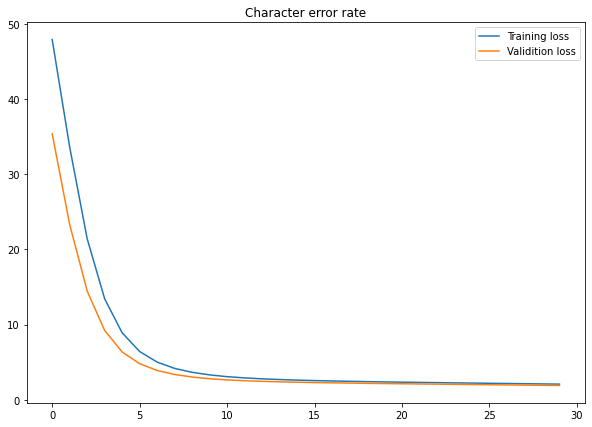

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validition loss')
plt.legend()
plt.title('Character error rate')
plt.show()

In [26]:
get_per(data_loader_val_letters,cpc_model,character_classifier)

N/A% (0 of 47) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (47 of 47) |########################| Elapsed Time: 0:04:50 Time:  0:04:50


Average PER 0.8179949902901508


0.8179949902901508

## Evaluation with the TestSet

In [27]:
get_per(data_loader_test_letters,cpc_model,character_classifier)

N/A% (0 of 133) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (133 of 133) |######################| Elapsed Time: 0:59:25 Time:  0:59:25


Average PER 0.4477462336308168


0.4477462336308168